## Treecode by Barnes, Hut

`treecode` is a NBody code developed by Barnes in 2005.

In the direct NBody you calculate the forces $F_{ij}$ for all possible particle pairs, hence $N^2$ computation time. 

The treecode instead searches for the maximum volume enclosing all particles, a cube that defines the *domain of the simulation*. Then, it subdivides iteratively this domain when its necessary to compute forces that cant be averaged.<br>
The Barnes code is an `oct-tree`, meaning that the domain gets splitted in 8 equal parts.

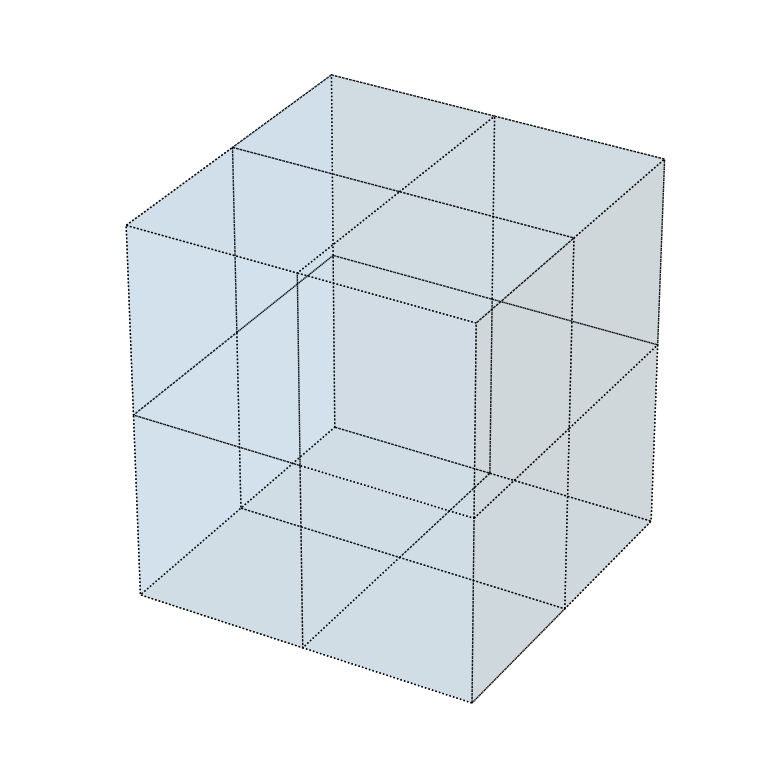

In [62]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('../sim.mplstyle')
%config InlineBackend.figure_format = 'retina'

axes = [2, 2, 2]
data = np.ones(axes)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set(aspect='equal')
ax.set_axis_off()
ax.grid(visible=False)
ax.voxels(data, alpha=.1,edgecolors='k', lw=.5, ls='dotted');

So the `treecode` splits the domain in 8 equal parts iteratively until a single particle is resolved. 

If the particles are very close to eachother you directly sum their forces like `nbody_sh1`, if they are sufficiently far away from the particle you're calculating the field for, you instead group them and **treat them like a single particle** with total mass equal to the sum of the masses at position equal to the Center of Mass of that node.

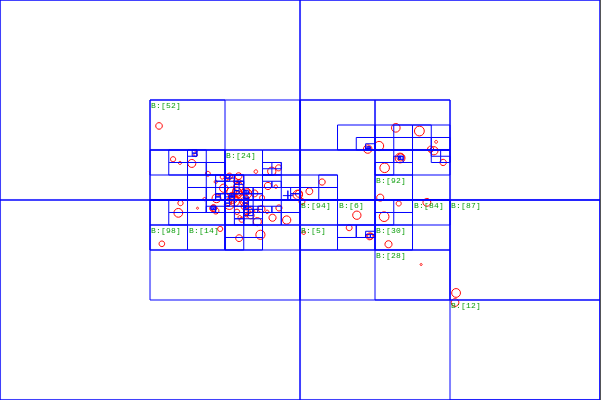

This follows the idea of the multipole expansion. This concept uses only monopoles, but one may find that a dipole term could be more accurate, there is an option in the treecode that allows for that freedom `usequad=true`. 

The criterion for opening a leaf of the tree is that the distance between the test mass and the particle follows the rule

$$
    \dfrac{l}{r} > \theta_\mathrm{crit}
$$

That is, the ratio between the side of the cube and the distance must be greater than a certain *accuracy parameter* if you want to open the leaf.


### Performance analysis
If the density is homogeneous, then if you take a sphere of radius $r$ and add a shell of radius $dr$, the number of particles inside that shell is 

$N(dr) = \rho \cdot V = 4\pi {dr}^2\rho$

Therefore $N(r+dr) = N(r) + 4\pi {dr}^2\rho = N(r) + dN(r)$ you can prove that the computation time is $N\log(N)$

### The softening parameter

Another thing that's different from `nbody_sh1` is that in this code the spatial resolution is *finite* due to the tree discretization. The maximum resolution is associated with $\epsilon$, the **softening parameter**.

As a consequence, we need to account for this minimum encounter distance in the force computation.

$$
    |\vec{f}_{ij}| = - G \sum_{j\neq i} \dfrac{m_im_j}{|\vec{r}_{ij}|^2 + \epsilon^2}
$$

which in vectorial form becomes

$$
    \vec{f}_{ij} = - G \sum_{j\neq i} \dfrac{m_im_j}{|\vec{r}_{ij}|^2 + \epsilon^2}\ \hat r_{ij}
$$

The result is that if $\epsilon \ll |\vec{r}_{ij}|^2$, that is the particles are much more separated than the resolution unit distance, the effect is basically neglegible, the forces don't change.

However, for small distances $\epsilon \sim |\vec{r}_{ij}|^2$, then it is as if the particles were distributed instead of being point particles. 

This reduces the gravitational interaction and reduces scattering intensity at small distances.

We can imagine the softening as the 'size' of the particles and estimate this parameter as 

$$
    \epsilon =  \left(\dfrac{V_D}{N}\right)^{1/3}
$$

### Time integration scheme
In this context the Hermite integration is overkill, we have a finite domain so we can use a finite differencing scheme such as the **leapfrog** method.<br>
For the $n$-th timestep you update the motion momenta as follows, you start by computing the velocity for half a timestep

$$
    v_{n+\frac{1}{2}} = v_n + \frac{\Delta t}{2}a_n
$$

where $\Delta t$ is the timestep duration and $a_n$ is calculated from the force. Then you update the position using $v_{n+\frac{1}{2}}$ which is basically the average velocity between timestep $n$ and $n+1$

$$
    r_{n+1} = r_n + \Delta t\ v_{n+\frac{1}{2}}
$$

Finally you correct the velocity by computing it as follows

$$
    v_{n+1} = v_{n+\frac{1}{2}} + \frac{\Delta t}{2} a_{n+1}
$$

we use the forces computed at time $n+1$.

This code differes from `nbody_sh1` also because in this code the timestep is **fixed** and not dynamically calculated (min between r/v and r^2/a), so *you have to think in advance*. 

You have to estimate the correct timestep on your own. For example, in the collapse of a homogeneous sphere, the time of collapse depends on how accurate the timestep is. If you want your collapse to be very acccurate a good choice would be setting

$$
    dt = T_\mathrm{dyn}\cdot 10^{-4}
$$